<a href="https://colab.research.google.com/github/rnaarla/GoogleLabsAIAgents/blob/main/options_strategy_helper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install --upgrade pip
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow mplcursors pandas-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


Enter the stock ticker symbol (e.g., 'AAPL' for Apple Inc.): NVDA


[*********************100%%**********************]  1 of 1 completed


Fetched data for NVDA: (125, 6)
Data with indicators:                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-15  130.559998  131.389999  127.180000  128.440002  128.440002   
2024-07-16  128.440002  129.039993  124.580002  126.360001  126.360001   
2024-07-17  121.349998  121.849998  116.720001  117.989998  117.989998   
2024-07-18  121.849998  122.400002  116.559998  121.089996  121.089996   
2024-07-19  120.349998  121.599998  117.370003  117.930000  117.930000   

               Volume         SMA      EMA_12      EMA_26      MACD  RSI  
Date                                                                      
2024-07-15  208326200  127.190715  127.993807  124.012755  3.981051  NaN  
2024-07-16  214769500  127.210001  127.742452  124.186625  3.555827  NaN  
2024-07-17  390086200  126.609287  126.242074  123.727616  2.514459  NaN  
2024-07-18  320979500  126.402144  125.449447  123.5

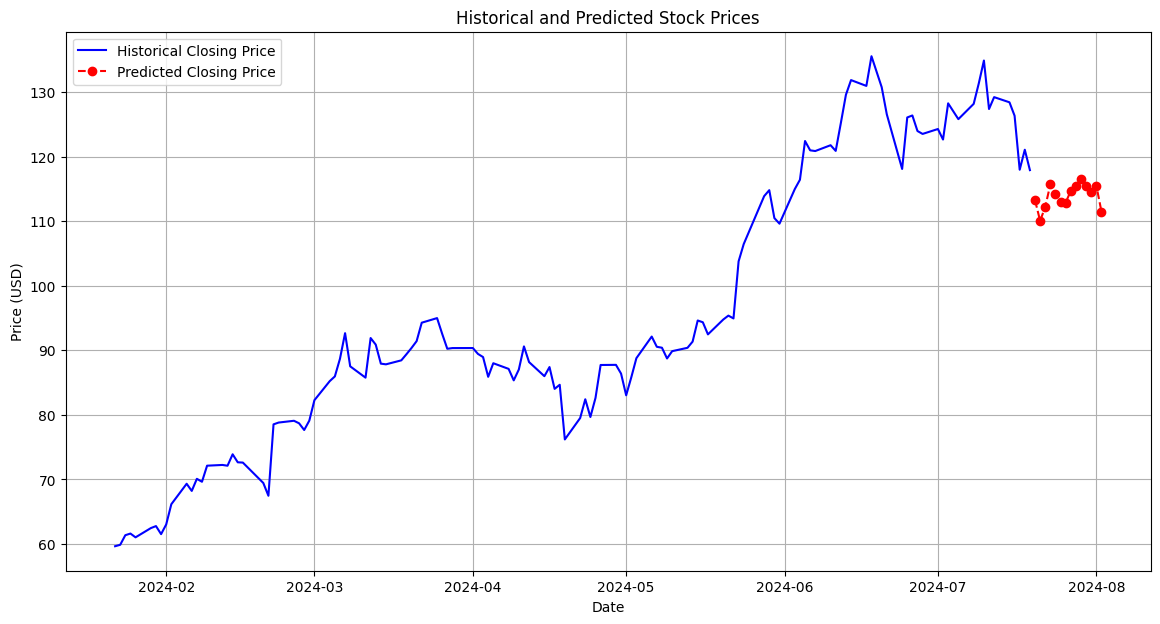


Predicted Prices for the Next 14 Days:
Ticker       Date  Predicted Closing Price
  NVDA 2024-07-20               113.273422
  NVDA 2024-07-21               110.069153
  NVDA 2024-07-22               112.245247
  NVDA 2024-07-23               115.716217
  NVDA 2024-07-24               114.297340
  NVDA 2024-07-25               112.937126
  NVDA 2024-07-26               112.899368
  NVDA 2024-07-27               114.724327
  NVDA 2024-07-28               115.535797
  NVDA 2024-07-29               116.518723
  NVDA 2024-07-30               115.485207
  NVDA 2024-07-31               114.536354
  NVDA 2024-08-01               115.508751
  NVDA 2024-08-02               111.517967
Total execution time: 26.62 seconds


In [24]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import mplcursors
import time
import pandas_datareader as pdr
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to fetch stock data with retry logic
def fetch_stock_data_with_retry(ticker_symbol, retries=3, delay=5):
    for attempt in range(retries):
        try:
            data = yf.download(ticker_symbol, period='6mo', interval='1d')
            print(f"Fetched data for {ticker_symbol}: {data.shape}")
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(delay)
    print(f"Failed to fetch data for {ticker_symbol} after {retries} attempts.")
    return None

# Function to calculate technical indicators
def calculate_indicators(data):
    if 'Close' not in data.columns:
        print("Required column 'Close' not found in the data.")
        return None

    data['SMA'] = data['Close'].rolling(window=14).mean()
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']

    if not pd.api.types.is_numeric_dtype(data['Close']):
        print("Non-numeric data found in 'Close' column.")
        data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    return data

# Function to prepare data for LSTM
def prepare_lstm_data(data, sequence_length=60, forecast_period=14):
    if data.empty:
        print("No data available for the given ticker symbol.")
        return None, None, None
    if len(data) < sequence_length + forecast_period:
        print("Insufficient data: At least {} days of data are required.".format(sequence_length + forecast_period))
        return None, None, None
    if 'Close' not in data.columns:
        print("Required column 'Close' not found in the data.")
        return None, None, None

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    print(f"Scaled data shape: {scaled_data.shape}")

    X = []
    y = []

    for i in range(len(scaled_data) - sequence_length - forecast_period + 1):
        X_seq = scaled_data[i:i + sequence_length]
        y_seq = scaled_data[i + sequence_length:i + sequence_length + forecast_period]

        if len(y_seq) == forecast_period:
            X.append(X_seq)
            y.append(y_seq)

    X = np.array(X)
    y = np.array(y)

    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    if len(X) == 0 or len(y) == 0:
        print("Error: X and y arrays are empty")
        return None, None, None

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Function to build and train LSTM model
def build_and_train_lstm(X, y, forecast_period=14):
    try:
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
        model.add(LSTM(units=50))
        model.add(Dense(units=forecast_period))  # Ensure output units match the forecast period
        model.compile(optimizer='adam', loss='mean_squared_error')

        es = EarlyStopping(monitor='loss', patience=10)
        model.fit(X, y, epochs=100, batch_size=32, callbacks=[es])

        return model
    except Exception as e:
        print(f"Error occurred during model training: {e}")
        return None

# Function to predict future prices
def predict_future_prices(model, data, scaler, forecast_period=14):
    if data.empty:
      print("No data available for prediction.")
      return []

    if len(data) < 60:
        print("Insufficient data: At least 60 days of data are required for prediction.")
        return []

    last_60_days = data['Close'][-60:].values.reshape(-1, 1)
    last_60_days_scaled = scaler.transform(last_60_days)

    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predicted_prices_scaled = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices_scaled)

    return predicted_prices[0] if predicted_prices.size > 0 else []

# Function to visualize results
def visualize_results(data, future_dates, predicted_prices):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Historical Closing Price', color='b')
    plt.plot(future_dates, predicted_prices, label='Predicted Closing Price', color='r', linestyle='--', marker='o')
    plt.title('Historical and Predicted Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)

    cursor = mplcursors.cursor(hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(
        f'Date: {pd.to_datetime(sel.target[0]).strftime("%Y-%m-%d")}\nPrice: {sel.target[1]:.2f}'))

    plt.show()

# Function to display prediction table
def display_prediction_table(ticker_symbol, future_dates, predicted_prices):
    table_data = {
        'Ticker': [ticker_symbol] * len(future_dates),
        'Date': future_dates.strftime('%Y-%m-%d'),
        'Predicted Closing Price': predicted_prices
    }
    table_df = pd.DataFrame(table_data)
    print(f"\nPredicted Prices for the Next {len(future_dates)} Days:")
    print(table_df.to_string(index=False))

# Main function
def main():
    ticker_symbol = input("Enter the stock ticker symbol (e.g., 'AAPL' for Apple Inc.): ").upper()
    data = fetch_stock_data_with_retry(ticker_symbol)

    if data is not None and not data.empty:
        try:
            start_time = time.time()

            data = calculate_indicators(data)
            if data is None:
                print("Failed to calculate indicators.")
                return

            print(f"Data with indicators: {data.tail()}")

            X, y, scaler = prepare_lstm_data(data)
            if X is not None and y is not None and scaler is not None:
                model = build_and_train_lstm(X, y)
                if model is not None:
                    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=14)
                    predicted_prices = predict_future_prices(model, data, scaler)

                    if len(predicted_prices) > 0:
                        print(f"Predicted prices: {predicted_prices}")

                        visualize_results(data, future_dates, predicted_prices)
                        display_prediction_table(ticker_symbol, future_dates, predicted_prices)

                    else:
                        print("Failed to predict prices.")

                    end_time = time.time()
                    print(f"Total execution time: {end_time - start_time:.2f} seconds")
        except Exception as e:
            print(f"Error occurred: {e}")
    else:
        print("No data available for the given ticker symbol.")

# Run the main function
if __name__ == "__main__":
    main()